In [1]:
from model import Actor, Critic, DRRAveStateRepresentation, PMF
from learn import DRRTrainer
from utils.general import csv_plot
import torch
import pickle
import numpy as np
import pandas as pd
import random
import os
import datetime

import matplotlib.pyplot as plt
 
%matplotlib inline

In [2]:
 class config():
    # output_path = 'results/' + datetime.datetime.now().strftime('%y%m%d-%H%M%S') + '/'
    output_path = 'results/' + '220623-084637/'
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plot_dir = output_path + 'rewards.pdf'
 
    train_actor_loss_data_dir = output_path + 'train_actor_loss_data.npy'
    train_critic_loss_data_dir = output_path + 'train_critic_loss_data.npy'
    train_mean_reward_data_dir = output_path + 'train_mean_reward_data.npy'
 
    train_actor_loss_plot_dir = output_path + 'train_actor_loss.png'
    train_critic_loss_plot_dir = output_path + 'train_critic_loss.png'
    train_mean_reward_plot_dir = output_path + 'train_mean_reward.png'
 
    trained_models_dir = 'trained/'
 
    actor_model_trained = trained_models_dir + 'actor_net.weights'
    critic_model_trained = trained_models_dir + 'critic_net.weights'
    state_rep_model_trained = trained_models_dir + 'state_rep_net.weights'
 
    actor_model_dir = output_path + 'actor_net.weights'
    critic_model_dir = output_path + 'critic_net.weights'
    state_rep_model_dir = output_path + 'state_rep_net.weights'
 
    csv_dir = output_path + 'log.csv'
 
    path_to_trained_pmf = trained_models_dir + 'eComm_ratio_0.800000_bs_256_e_25_wd_0.100000_lr_0.000100_trained_pmf.pt'
 
    # hyperparams
    batch_size = 128
    gamma = 0.9
    replay_buffer_size = 100000
    history_buffer_size = 5
    learning_start = 1000 #500
    learning_freq = 1
    lr_state_rep = 0.001
    lr_actor = 0.0001
    lr_critic = 0.001
    eps_start = 1
    eps = 0.1
    eps_steps = 10000
    eps_eval = 0.1
    tau = 0.01 # inital 0.001
    beta = 0.4
    prob_alpha = 0.3
    max_timesteps_train = 15000
    max_epochs_offline = 500
    max_timesteps_online = 2000
    embedding_feature_size = 100
    episode_length = 10
    train_ratio = 0.8
    weight_decay = 0.01
    clip_val = 1.0
    log_freq = 1000
    saving_freq = 1000
    zero_reward = False
 
    no_cuda = True
    
    logs_dir = 'runs/' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')

def seed_all(cuda, seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.empty_cache()
        torch.cuda.manual_seed(seed=seed)

In [3]:
print("Initializing DRR Framework ----------------------------------------------------------------------------")
 
# Get CUDA device if available
cuda = True if not config.no_cuda and torch.cuda.is_available() else False
print("Using CUDA") if cuda else print("Using CPU")
 
 
# Init seeds
seed_all(cuda, 0)
print("Seeds initialized")
 
# Grab models
actor_function = Actor
critic_function = Critic
state_rep_function = DRRAveStateRepresentation

Initializing DRR Framework ----------------------------------------------------------------------------
Using CPU
Seeds initialized


In [4]:
 
# Import Data

data_df = pd.read_csv('dataset/eComm-sample-data2.csv')

In [5]:
event_type_to_num = {'view': 1, 'cart': 2, 'purchase': 3}
data_df['behavior'] = data_df['event_type'].apply(lambda x : event_type_to_num[x])

items = dict(zip(data_df['product_id'], data_df['product_id_num']))
users = dict(zip(data_df['user_id'], data_df['user_id_num']))

NUM_USERS, NUM_ITEMS = len(users), len(items)
print(NUM_USERS, NUM_ITEMS)

data = data_df.loc[:, ['user_id_num', 'product_id_num', 'behavior', 'event_time']].values

5309 15184


In [6]:
np.unique(data[:, 2])

array([1, 2, 3])

In [7]:
np.random.shuffle(data)
train_data = torch.from_numpy(data[:int(config.train_ratio * data.shape[0])])
test_data = torch.from_numpy(data[int(config.train_ratio * data.shape[0]):])
print("Data imported, shuffled, and split into Train/Test, ratio=", config.train_ratio)
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)
 

Data imported, shuffled, and split into Train/Test, ratio= 0.8
Train data shape:  torch.Size([100427, 4])
Test data shape:  torch.Size([25107, 4])


In [8]:
# Create and load PMF function for rewards and embeddings
reward_function = PMF(NUM_USERS, NUM_ITEMS, config.embedding_feature_size, is_sparse=False, no_cuda=~cuda)
reward_function.load_state_dict(torch.load(config.path_to_trained_pmf))
 
# Freeze all the parameters in the network
for param in reward_function.parameters():
    param.requires_grad = False
print("Initialized PMF, imported weights, created reward_function")
 
# Extract embeddings
user_embeddings = reward_function.user_embeddings.weight.data
item_embeddings = reward_function.item_embeddings.weight.data
print("Extracted user and item embeddings from PMF")
print("User embeddings shape: ", user_embeddings.shape)
print("Item embeddings shape: ", item_embeddings.shape)
 

Initialized PMF, imported weights, created reward_function
Extracted user and item embeddings from PMF
User embeddings shape:  torch.Size([5309, 100])
Item embeddings shape:  torch.Size([15184, 100])


In [9]:
# Init trainer
print("Initializing DRRTrainer -------------------------------------------------------------------------------")
trainer = DRRTrainer(config,
                      actor_function,
                      critic_function,
                      state_rep_function,
                      reward_function,
                      users,
                      items,
                      train_data,
                      test_data,
                      user_embeddings,
                      item_embeddings,
                      cuda
                      )

Initializing DRRTrainer -------------------------------------------------------------------------------
Current PyTorch Device:  cpu
Data dimensions extracted
Models initialized
Model weights initialized, copied to target
Optimizers initialized


In [10]:
config.learning_start

1000

In [11]:
#Train
# print("Starting DRRTrainer.learn() ---------------------------------------------------------------------------")
# actor_losses, critic_losses, epi_avg_rewards = trainer.learn()

Starting DRRTrainer.learn() ---------------------------------------------------------------------------


/Users/ankurdhuriya/RL_UseCase/drr_restaurants/learn.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))
/Users/ankurdhuriya/miniconda3/envs/drr_pytorch/lib/python3.10/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Timestep 1000 | Episode 99 | Mean Ep R 5.0000 | Max R 5.0000 | Critic Params Norm 18.1686 | Actor Loss -56.7445 | Critic Loss 1.3510 | 
Timestep 2000 | Episode 199 | Mean Ep R 5.0000 | Max R 5.0000 | Critic Params Norm 14.8301 | Actor Loss -78.5415 | Critic Loss 1.5261 | 
Timestep 3000 | Episode 299 | Mean Ep R 10.0000 | Max R 10.0000 | Critic Params Norm 138.8887 | Actor Loss -87.2211 | Critic Loss 2.5426 | 
Timestep 4000 | Episode 399 | Mean Ep R 5.0000 | Max R 5.0000 | Critic Params Norm 89.5983 | Actor Loss -82.7561 | Critic Loss 1.9183 | 
Timestep 5000 | Episode 499 | Mean Ep R 5.0000 | Max R 5.0000 | Critic Params Norm 13.9229 | Actor Loss -84.6599 | Critic Loss 0.8592 | 
Timestep 6000 | Episode 599 | Mean Ep R 5.0000 | Max R 5.0000 | Critic Params Norm 60.4037 | Actor Loss -77.8338 | Critic Loss 1.7805 | 
Timestep 7000 | Episode 699 | Mean Ep R 5.0000 | Max R 5.0000 | Critic Params Norm 43.7084 | Actor Loss -70.1640 | Critic Loss 1.2753 | 
Timestep 8000 | Episode 799 | Mean Ep R

In [11]:
config.trained_models_dir = "results/220623-084637/"
output_path = "results/220623-084637/"

train_actor_loss_data_dir = output_path + 'train_actor_loss_data.npy'
train_critic_loss_data_dir = output_path + 'train_critic_loss_data.npy'
train_mean_reward_data_dir = output_path + 'train_mean_reward_data.npy'

config.actor_model_trained = config.trained_models_dir + 'actor_net.weights'
config.critic_model_trained = config.trained_models_dir + 'critic_net.weights'
config.state_rep_model_trained = config.trained_models_dir + 'state_rep_net.weights'

In [12]:
import matplotlib.pyplot as plt
from tsmoothie.smoother import ConvolutionSmoother

In [13]:
def noiseless_plot(y, title, ylabel, save_loc):
    smoother = ConvolutionSmoother(window_len=1000, window_type='ones')
    smoother.smooth(y)

    # generate intervals
    low, up = smoother.get_intervals('sigma_interval', n_sigma=3)

    # plot the smoothed timeseries with intervals
    plt.close()
    plt.figure(figsize=(11,6))
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.plot(smoother.data[0], color='orange')
    plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
    plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
    plt.savefig(save_loc)
    plt.close()

In [14]:
actor_losses = np.load(train_actor_loss_data_dir)
critic_losses = np.load(train_critic_loss_data_dir)
epi_avg_rewards = np.load(train_mean_reward_data_dir)

noiseless_plot(actor_losses, 
               "Actor Loss (Train)", 
               "Actor Loss (Train)", 
               output_path + "train_actor_loss_smooth.png")
               
noiseless_plot(critic_losses, 
               "Critic Loss (Train)", 
               "Critic Loss (Train)", 
               output_path + "train_critic_loss_smooth.png")

noiseless_plot(epi_avg_rewards, 
               "Mean Reward (Train)", 
               "Mean Reward (Train)", 
               output_path + "train_mean_reward_smooth.png")

In [15]:
# source hyperparameters

sourceFile = open(output_path + "hyperparams.txt", 'w')
print(config.__dict__, file = sourceFile)
sourceFile.close()

In [16]:
T_precisions = [3, 5, 10, 15]

In [17]:
trainer.discretize_reward_(torch.tensor(2.1))

tensor(10., dtype=torch.float64)

/Users/ankurdhuriya/miniconda3/envs/drr_pytorch/lib/python3.10/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/Users/ankurdhuriya/RL_UseCase/drr_restaurants/learn.py:935: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Offline Evaluation Finishedrd 10.0
Average Precision@3: 0.4328 | 
Offline Evaluation Finishedrd 10.0
Average Precision@3: 0.4094 | 
Offline Evaluation Finishedrd 5.00
Average Precision@3: 0.3976 | 
Offline Evaluation Finishedrd 5.00
Average Precision@3: 0.3848 | 
Offline Evaluation Finishedrd 10.0
Average Precision@3: 0.4310 | 
Offline Evaluation Finishedrd 10.0
Average Precision@3: 0.3707 | 
Offline Evaluation Finishedd 5.0.0
Average Precision@3: 0.4043 | 
Offline Evaluation Finishedrd 10.0
Average Precision@3: 0.4073 | 
Offline Evaluation Finishedrd 5.00
Average Precision@3: 0.4204 | 
Offline Evaluation Finishedrd 5.00
Average Precision@3: 0.3720 | 
Offline Evaluation Finishedrd 5.00
Average Precision@3: 0.3952 | 
Offline Evaluation Finishedrd 5.00
Average Precision@3: 0.4063 | 
Offline Evaluation Finishedd 5.000
Average Precision@3: 0.3865 | 
Offline Evaluation Finishedrd 10.0
Average Precision@3: 0.4279 | 
Offline Evaluation Finishedrd 5.00
Average Precision@3: 0.4446 | 
Offline Ev

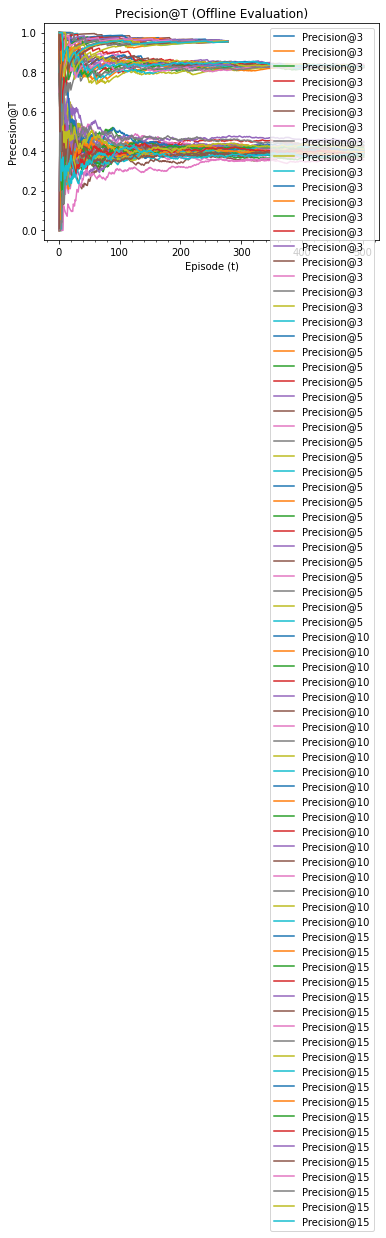

In [18]:
for T_precision in T_precisions:
    pmf_Ts = []
    for i in range(20):
        # Evaluate
        avg_precision = trainer.offline_pmf_evaluate(T_precision)

        # Append to list
        pmf_Ts.append(avg_precision)

    # Save data
    pmf_Ts = np.array(pmf_Ts)
    np.save(output_path + f'avg_precision@{T_precision}_offline_pmf_eval.npy', pmf_Ts)

    # Save
    sourceFile = open(output_path + f'avg_precision@{T_precision}_offline_pmf_eval.txt', 'w')
    print(f'Average Precision@{T_precision} (Eval): {np.mean(pmf_Ts)}', file=sourceFile)
    sourceFile.close()